In [ ]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from itertools import islice


from utils import utils

pd.options.display.float_format = "{:,.3f}".format

import importlib

try:
    importlib.reload(utils)  # reload module
except NameError:
    pass

# Read and Clean Dataset

In [2]:
path = "input/default of credit card clients.xls"
df = pd.read_excel(path, header=1)

df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [3]:
# Clean column names
df_clean = (df.rename(columns=lambda c: c.lower().replace(' ', '_').replace('-', '_')))

# Set columns to appropriate types
int_col = ["id", "sex", "education", "marriage", "default_payment_next_month"]
df_clean = (df_clean
    .assign(**{col: df_clean[col].astype(float) for col in df_clean.columns if col not in int_col})
    .assign(**{col: df_clean[col].astype(int) for col in df_clean.columns if col in int_col})
    .rename(columns={"pay_0": "pay_1"})
)

df_clean.head()

,id,limit_bal,sex,education,marriage,age,pay_1,pay_2,pay_3,pay_4,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default_payment_next_month
0,1,"20,000.000",2,2,1,24.000,2.000,2.000,-1.000,-1.000,...,0.000,0.000,0.000,0.000,689.000,0.000,0.000,0.000,0.000,1
1,2,"120,000.000",2,2,2,26.000,-1.000,2.000,0.000,0.000,...,"3,272.000","3,455.000","3,261.000",0.000,"1,000.000","1,000.000","1,000.000",0.000,"2,000.000",1
2,3,"90,000.000",2,2,2,34.000,0.000,0.000,0.000,0.000,...,"14,331.000","14,948.000","15,549.000","1,518.000","1,500.000","1,000.000","1,000.000","1,000.000","5,000.000",0
3,4,"50,000.000",2,2,1,37.000,0.000,0.000,0.000,0.000,...,"28,314.000","28,959.000","29,547.000","2,000.000","2,019.000","1,200.000","1,100.000","1,069.000","1,000.000",0
4,5,"50,000.000",1,2,1,57.000,-1.000,0.000,-1.000,0.000,...,"20,940.000","19,146.000","19,131.000","2,000.000","36,681.000","10,000.000","9,000.000",689.000,679.000,0


# EDA

## Basic Overview

In [4]:
df_clean.shape

(30000, 25)

In [5]:
df_clean.describe().iloc[:, :12]

,id,limit_bal,sex,education,marriage,age,pay_1,pay_2,pay_3,pay_4,pay_5,pay_6
count,"30,000.000","30,000.000","30,000.000","30,000.000","30,000.000","30,000.000","30,000.000","30,000.000","30,000.000","30,000.000","30,000.000","30,000.000"
mean,"15,000.500","167,484.323",1.604,1.853,1.552,35.486,-0.017,-0.134,-0.166,-0.221,-0.266,-0.291
std,"8,660.398","129,747.662",0.489,0.790,0.522,9.218,1.124,1.197,1.197,1.169,1.133,1.150
min,1.000,"10,000.000",1.000,0.000,0.000,21.000,-2.000,-2.000,-2.000,-2.000,-2.000,-2.000
25%,"7,500.750","50,000.000",1.000,1.000,1.000,28.000,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000
50%,"15,000.500","140,000.000",2.000,2.000,2.000,34.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,"22,500.250","240,000.000",2.000,2.000,2.000,41.000,0.000,0.000,0.000,0.000,0.000,0.000
max,"30,000.000","1,000,000.000",2.000,6.000,3.000,79.000,8.000,8.000,8.000,8.000,8.000,8.000


In [6]:
df_clean.describe().iloc[:, 12:]

,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,default_payment_next_month
count,"30,000.000","30,000.000","30,000.000","30,000.000","30,000.000","30,000.000","30,000.000","30,000.000","30,000.000","30,000.000","30,000.000","30,000.000","30,000.000"
mean,"51,223.331","49,179.075","47,013.155","43,262.949","40,311.401","38,871.760","5,663.581","5,921.163","5,225.681","4,826.077","4,799.388","5,215.503",0.221
std,"73,635.861","71,173.769","69,349.387","64,332.856","60,797.156","59,554.108","16,563.280","23,040.870","17,606.961","15,666.160","15,278.306","17,777.466",0.415
min,"-165,580.000","-69,777.000","-157,264.000","-170,000.000","-81,334.000","-339,603.000",0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,"3,558.750","2,984.750","2,666.250","2,326.750","1,763.000","1,256.000","1,000.000",833.000,390.000,296.000,252.500,117.750,0.000
50%,"22,381.500","21,200.000","20,088.500","19,052.000","18,104.500","17,071.000","2,100.000","2,009.000","1,800.000","1,500.000","1,500.000","1,500.000",0.000
75%,"67,091.000","64,006.250","60,164.750","54,506.000","50,190.500","49,198.250","5,006.000","5,000.000","4,505.000","4,013.250","4,031.500","4,000.000",0.000
max,"964,511.000","983,931.000","1,664,089.000","891,586.000","927,171.000","961,664.000","873,552.000","1,684,259.000","896,040.000","621,000.000","426,529.000","528,666.000",1.000


## Data Quality

In [7]:
print("Null data point: ", df_clean.isna().sum().sum())

Null data point:  0


In [8]:
print("Duplicated rows: ", df.duplicated().sum())

Duplicated rows:  0


In [9]:
constant_cols = [col for col in df_clean.columns if df_clean[col].nunique() == 1]

near_constant_cols = [
    col for col in df_clean.columns if df_clean[col].value_counts(normalize=True).values[0] > 0.95
]

print("Constant columns:", constant_cols)
print("Near-constant columns:", near_constant_cols)

Constant columns: []
Near-constant columns: []


## Target Variable

In [10]:
df_clean["default_payment_next_month"].value_counts(dropna=False).to_frame().merge(
    df_clean["default_payment_next_month"].value_counts(normalize=True, dropna=False).to_frame(),
    left_index=True,
    right_index=True,
    suffixes=("_count", "_proportion"),
).reset_index()

,default_payment_next_month,count,proportion
0,0,23364,0.779
1,1,6636,0.221


## Categorical Features

In [11]:
for col in ["sex", "education", "marriage"]:
    data = df_clean[col].value_counts(dropna=False).to_frame().merge(
        df_clean[col].value_counts(normalize=True, dropna=False).to_frame(),
        left_index=True,
        right_index=True,
        suffixes=("_count", "_proportion"),
    ).sort_index()
    print(data)
    print()

     count  proportion
sex                   
1    11888       0.396
2    18112       0.604

           count  proportion
education                   
0             14       0.000
1          10585       0.353
2          14030       0.468
3           4917       0.164
4            123       0.004
5            280       0.009
6             51       0.002

          count  proportion
marriage                   
0            54       0.002
1         13659       0.455
2         15964       0.532
3           323       0.011



## Numerical Features

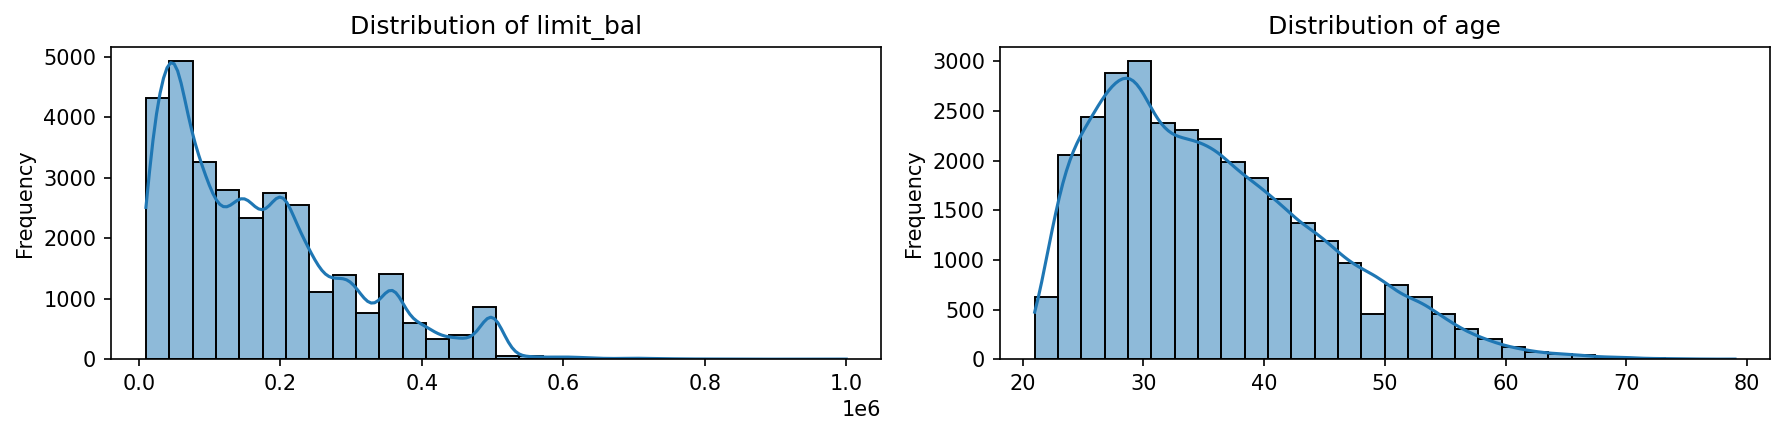

In [12]:
cols = [
    "limit_bal",
    "age",
]
fig = plt.figure(figsize=(12, 3), dpi=150)
for i, col in enumerate(cols):
    ax = plt.subplot(1, 2, i + 1)
    sns.histplot(df_clean[col], bins=30, kde=True, ax=ax)
    plt.title(f"Distribution of {col}")
    plt.xlabel("")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

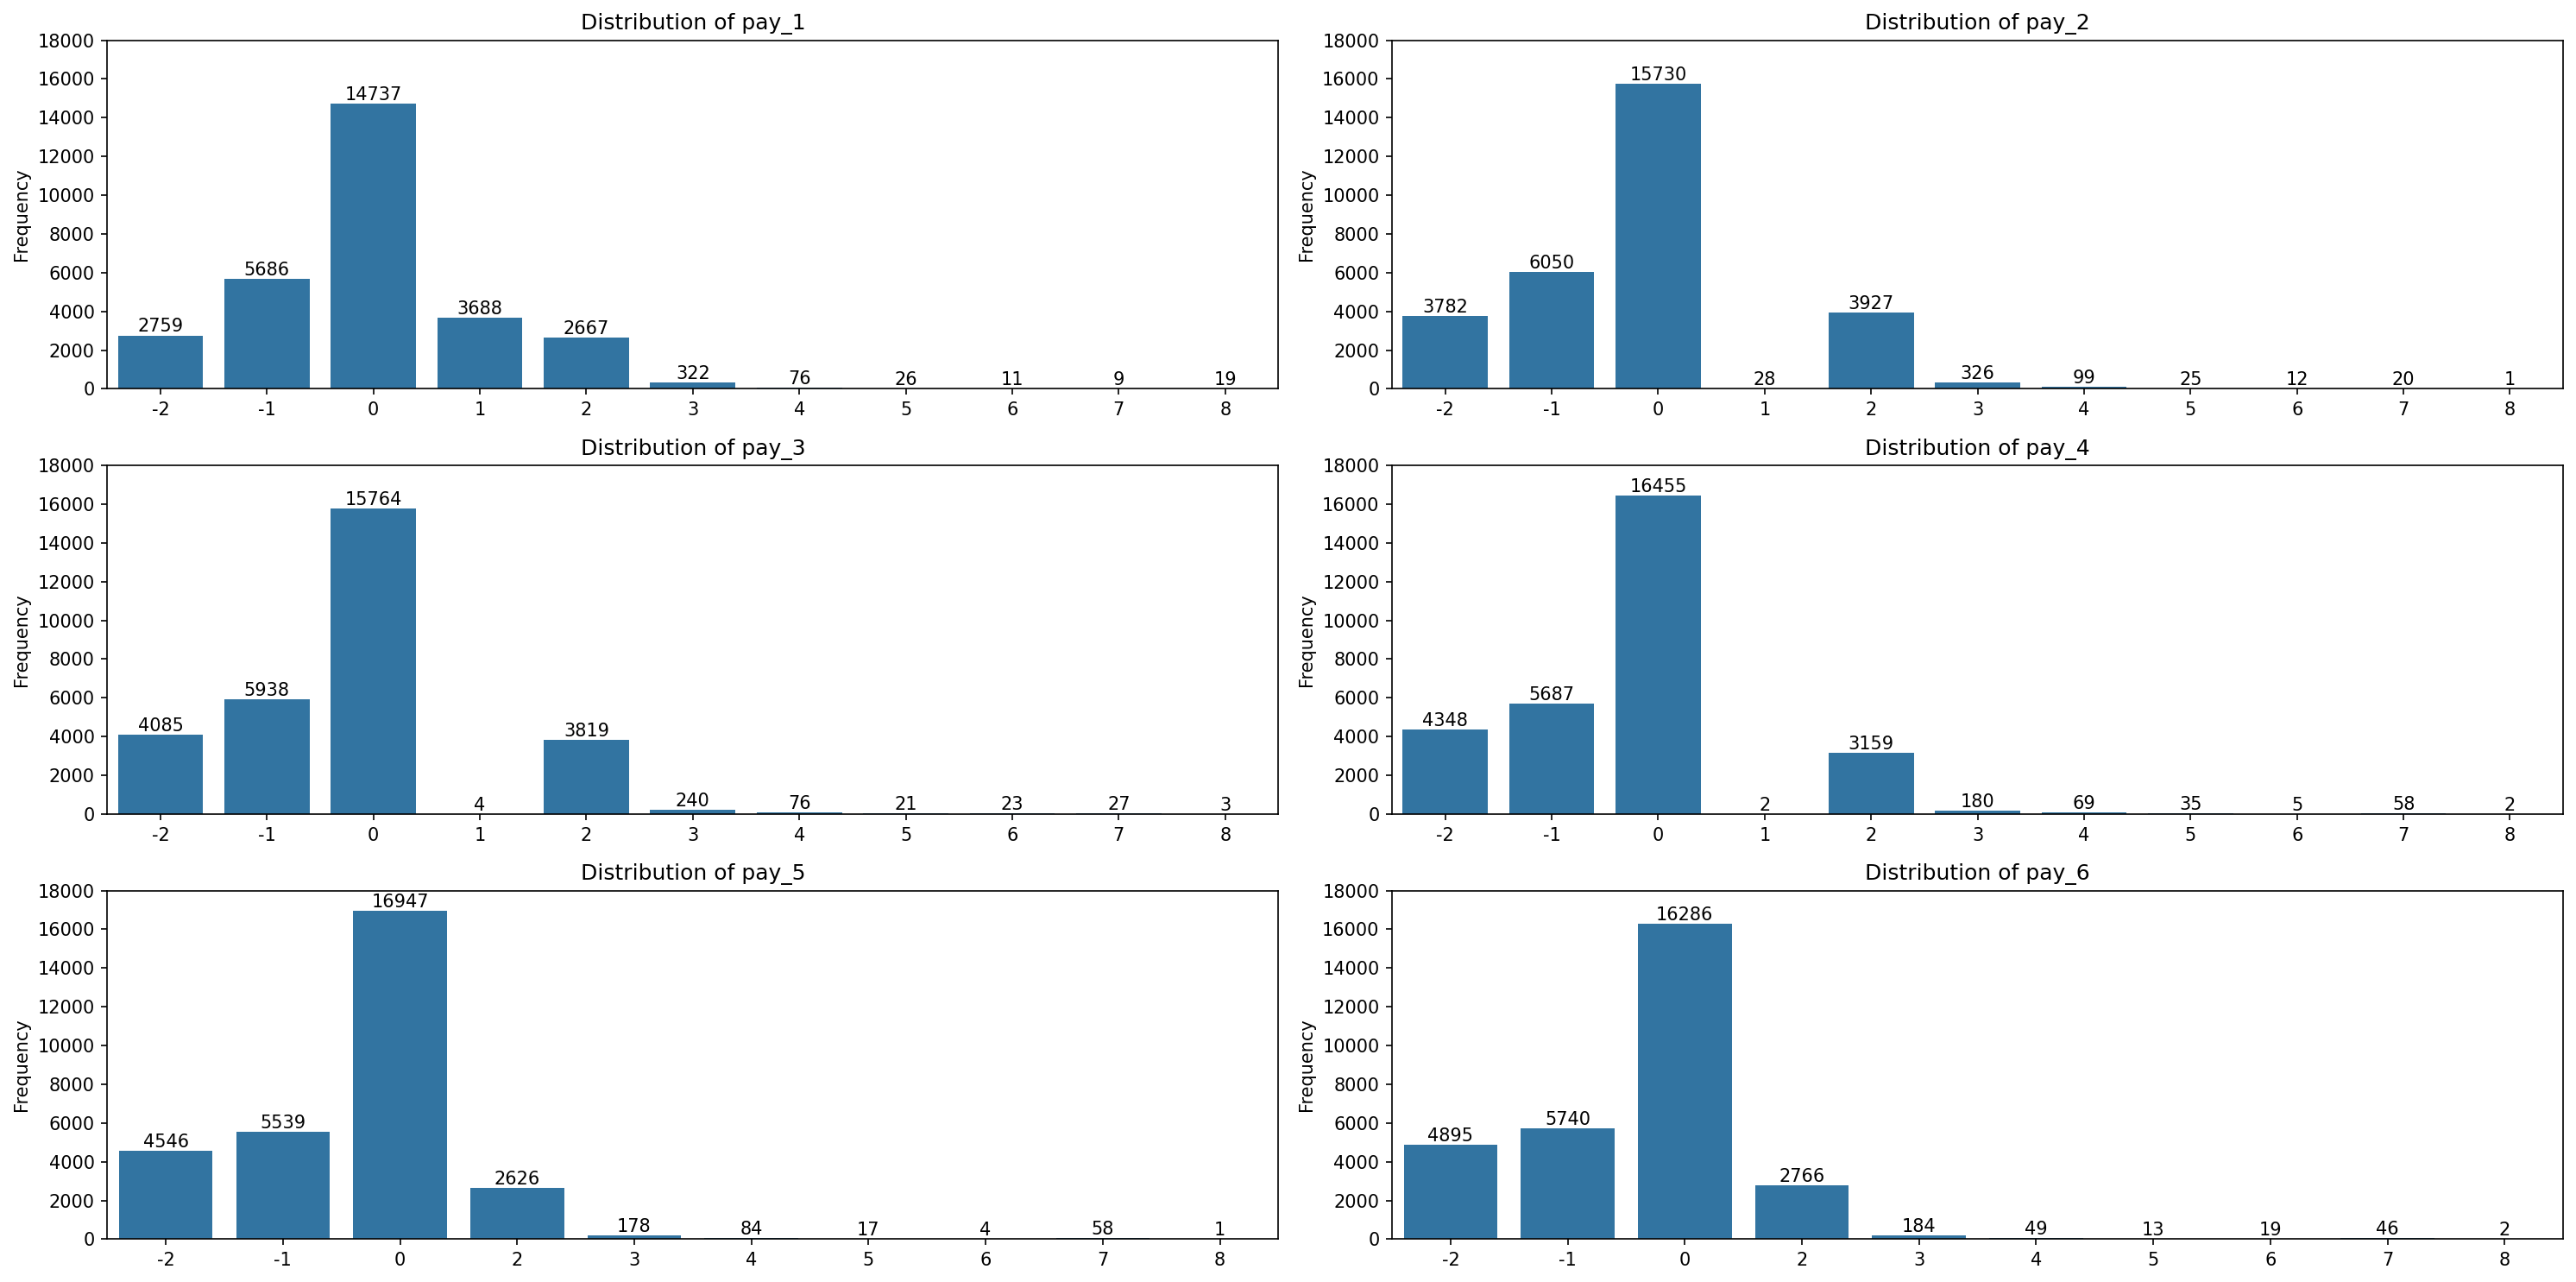

In [13]:
cols = [
    "pay_1",
    "pay_2",
    "pay_3",
    "pay_4",
    "pay_5",
    "pay_6",
]
fig = plt.figure(figsize=(20, 10), dpi=150)
for i, col in enumerate(cols):
    ax = plt.subplot(3, 2, i + 1)
    sns.barplot(x=df_clean[col].value_counts().index.astype(int), y=df_clean[col].value_counts().values, ax=ax)
    plt.title(f"Distribution of {col}")
    plt.xlabel("")
    plt.ylabel("Frequency")
    for p in ax.patches:
        height = p.get_height()
        ax.text(
            p.get_x() + p.get_width() / 2,  
            height + 0.5,                   
            int(height),                   
            ha='center',                   
            va='bottom'                    
        )
    ax.set_ylim(0, 18000)


plt.tight_layout()
plt.show()

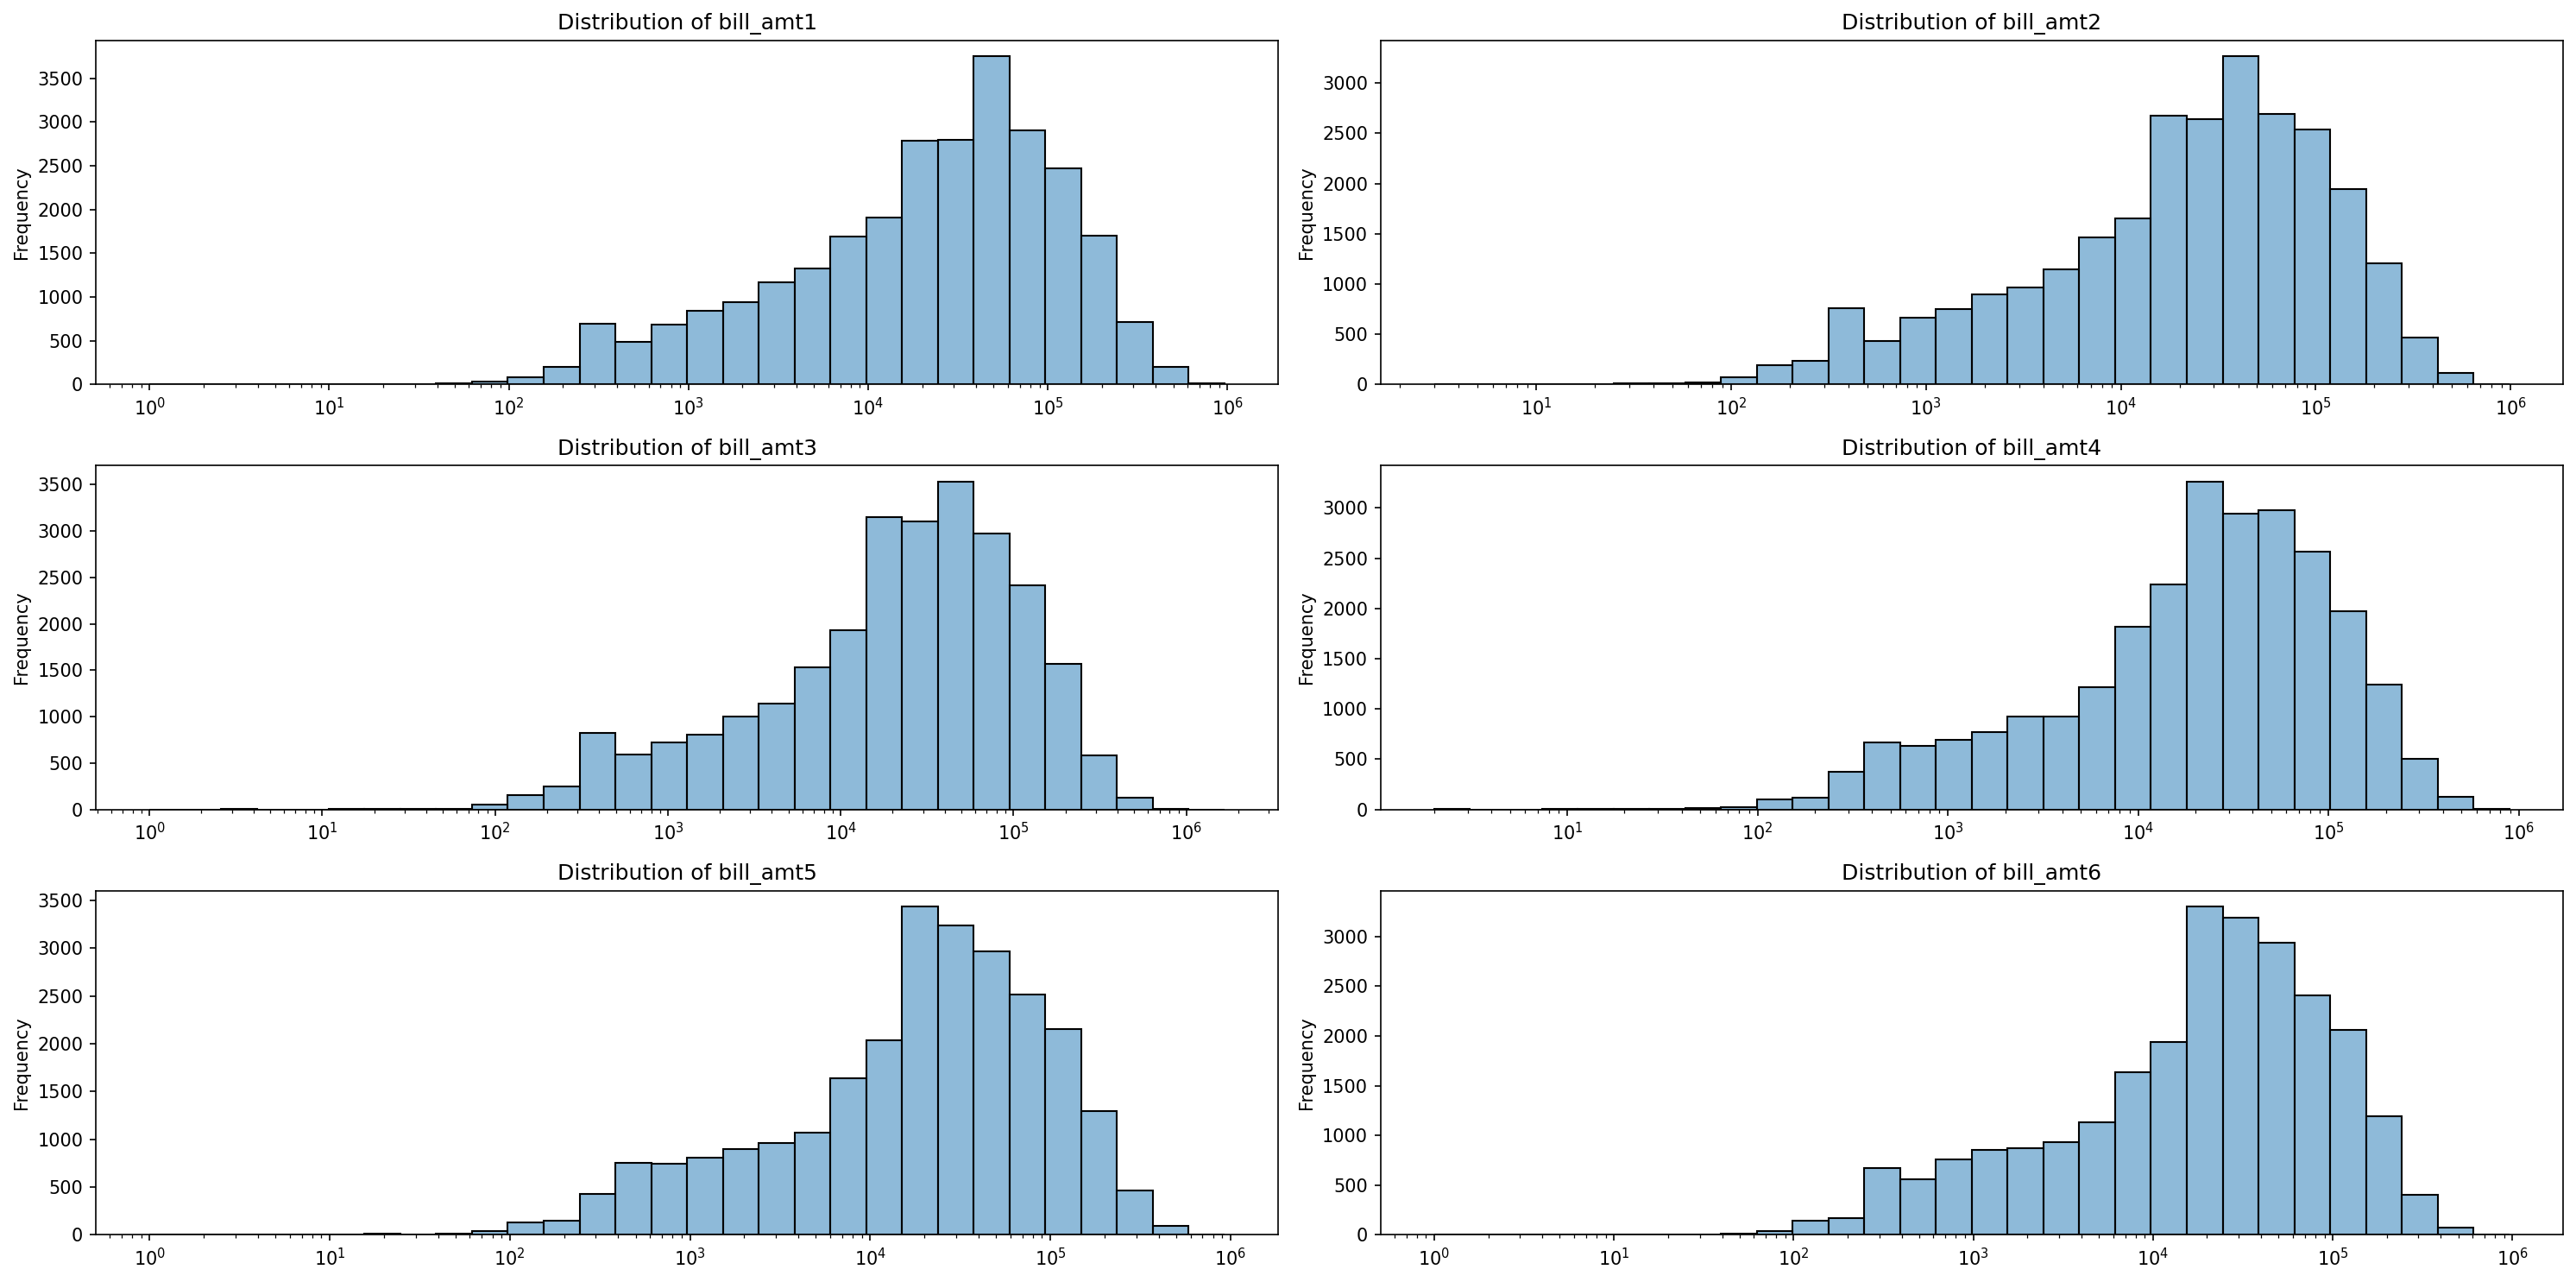

In [14]:
cols = [
    "bill_amt1",
    "bill_amt2",
    "bill_amt3",
    "bill_amt4",
    "bill_amt5",
    "bill_amt6",
]
fig = plt.figure(figsize=(20, 10), dpi=150)
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    for i, col in enumerate(cols):
        ax = plt.subplot(3, 2, i + 1)
        sns.histplot(df_clean[col], bins=30, kde=True, log_scale=True, ax=ax)
        plt.title(f"Distribution of {col}")
        plt.xlabel("")
        plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

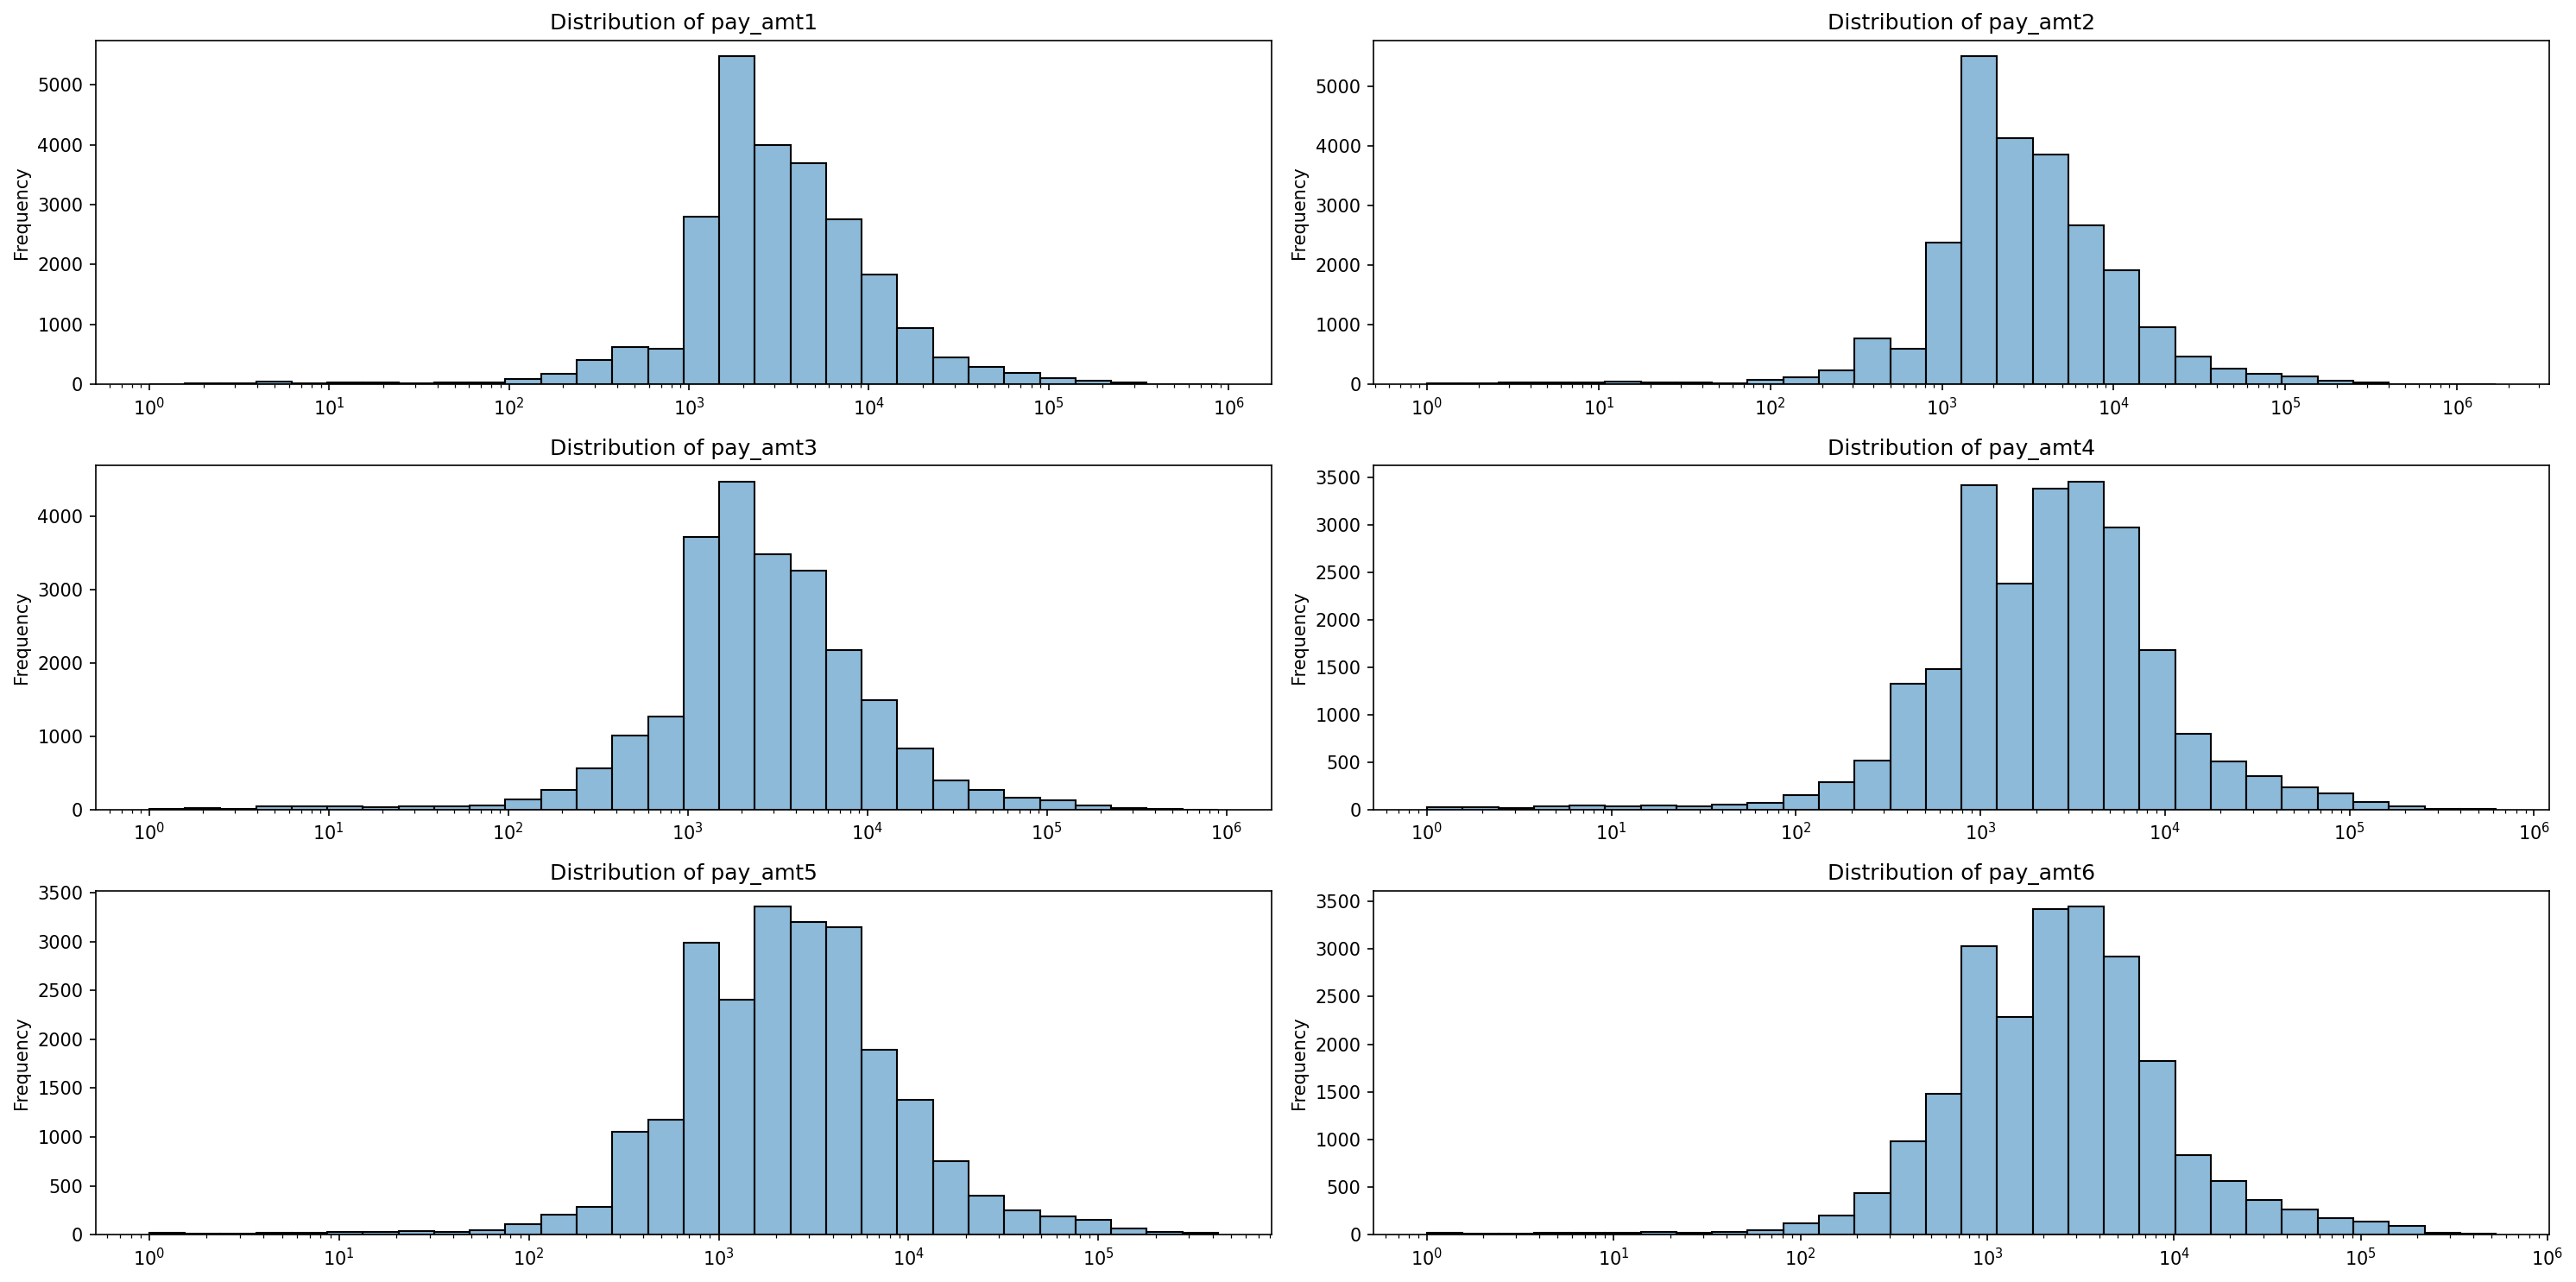

In [15]:
cols = [
    "pay_amt1",
    "pay_amt2",
    "pay_amt3",
    "pay_amt4",
    "pay_amt5",
    "pay_amt6",
]
fig = plt.figure(figsize=(20, 10), dpi=150)
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    for i, col in enumerate(cols):
        ax = plt.subplot(3, 2, i + 1)
        sns.histplot(df_clean[col], bins=30, kde=True, log_scale=True, ax=ax)
        plt.title(f"Distribution of {col}")
        plt.xlabel("")
        plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

## Time-Based Behavior

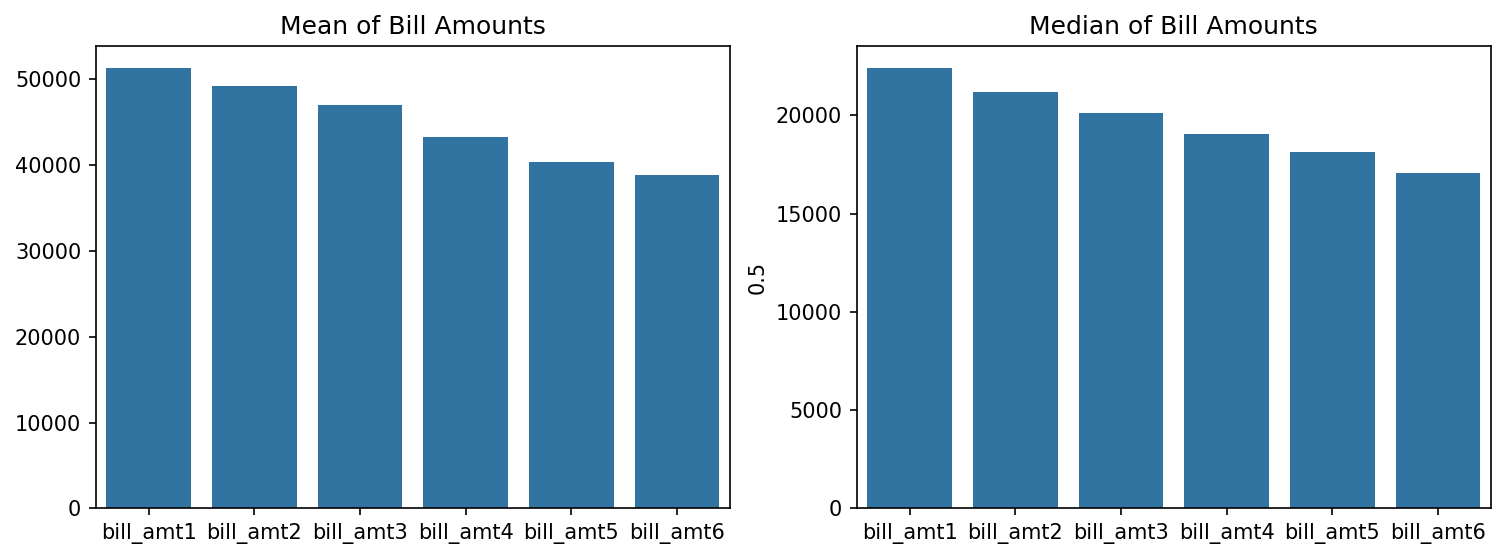

In [16]:
cols = [
    "bill_amt1",
    "bill_amt2",
    "bill_amt3",
    "bill_amt4",
    "bill_amt5",
    "bill_amt6",
]
means = df_clean[cols].mean()
medians = df_clean[cols].quantile(0.5)

fig = plt.figure(figsize=(12, 4), dpi=150)

ax = plt.subplot(1, 2, 1)
sns.barplot(means, ax=ax)
plt.title("Mean of Bill Amounts")

ax = plt.subplot(1, 2, 2)
sns.barplot(medians, ax=ax)
plt.title("Median of Bill Amounts")

plt.show()

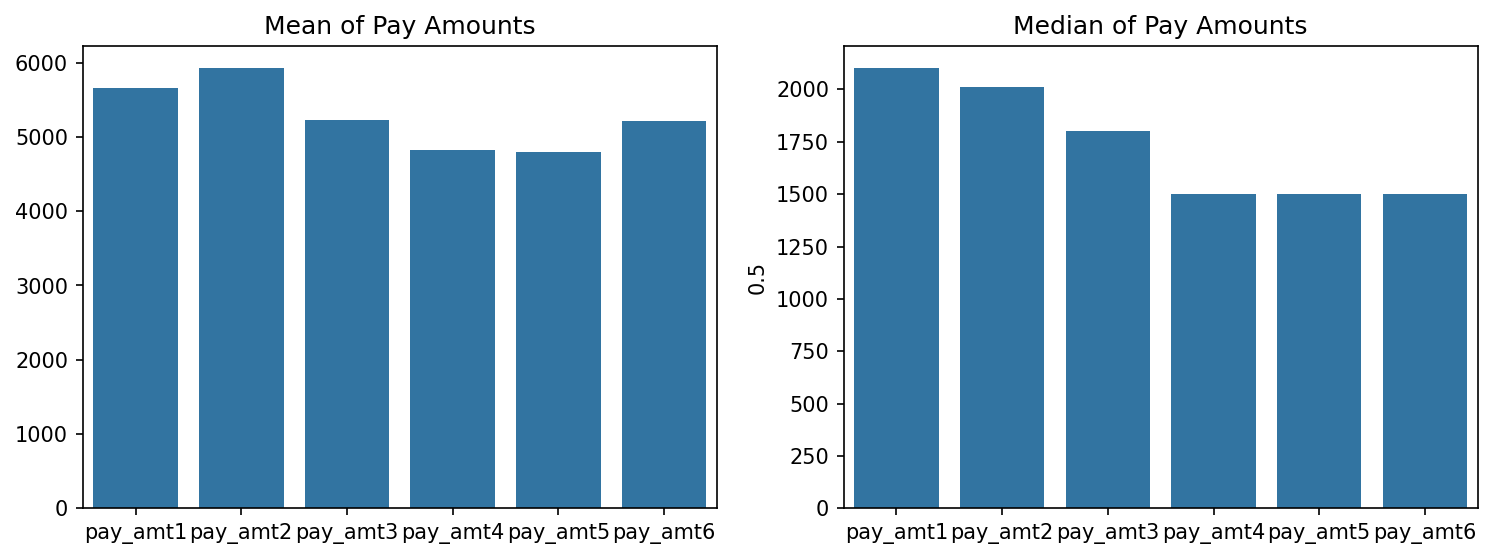

In [17]:
cols = [
    "pay_amt1",
    "pay_amt2",
    "pay_amt3",
    "pay_amt4",
    "pay_amt5",
    "pay_amt6",
]
means = df_clean[cols].mean()
medians = df_clean[cols].quantile(0.5)

fig = plt.figure(figsize=(12, 4), dpi=150)

ax = plt.subplot(1, 2, 1)
sns.barplot(means, ax=ax)
plt.title("Mean of Pay Amounts")

ax = plt.subplot(1, 2, 2)
sns.barplot(medians, ax=ax)
plt.title("Median of Pay Amounts")

plt.show()

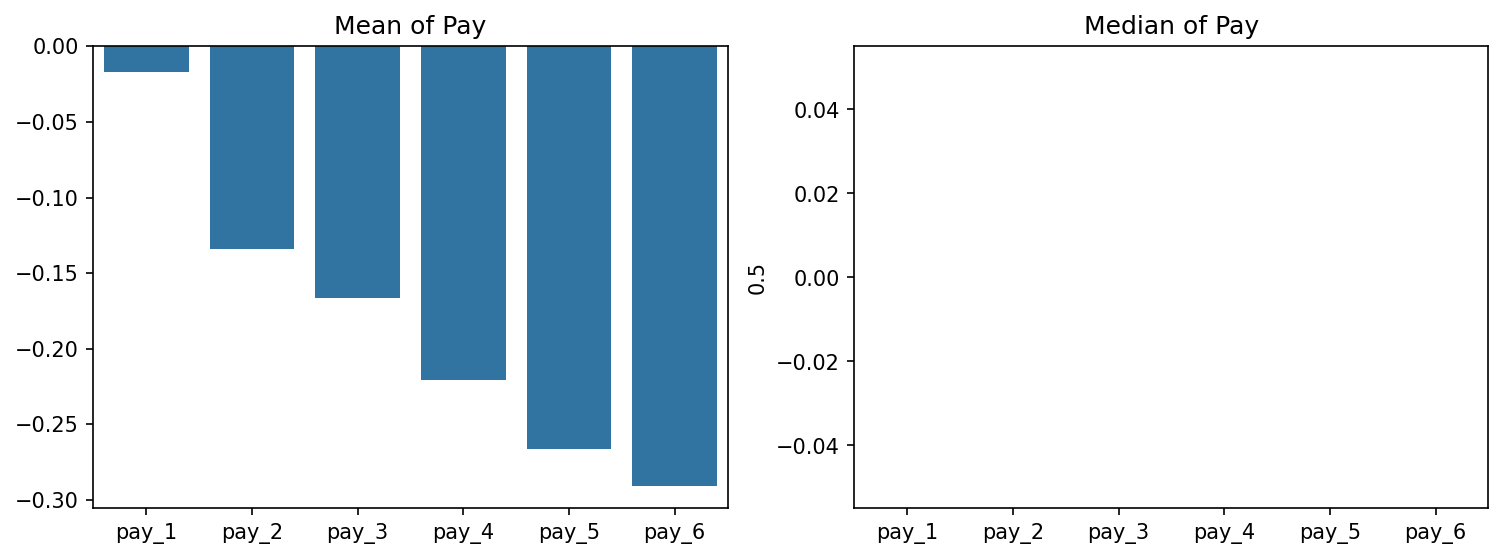

In [18]:
cols = [
    "pay_1",
    "pay_2",
    "pay_3",
    "pay_4",
    "pay_5",
    "pay_6",
]
means = df_clean[cols].mean()
medians = df_clean[cols].quantile(0.5)

fig = plt.figure(figsize=(12, 4), dpi=150)

ax = plt.subplot(1, 2, 1)
sns.barplot(means, ax=ax)
plt.title("Mean of Pay")

ax = plt.subplot(1, 2, 2)
sns.barplot(medians, ax=ax)
plt.title("Median of Pay")

plt.show()

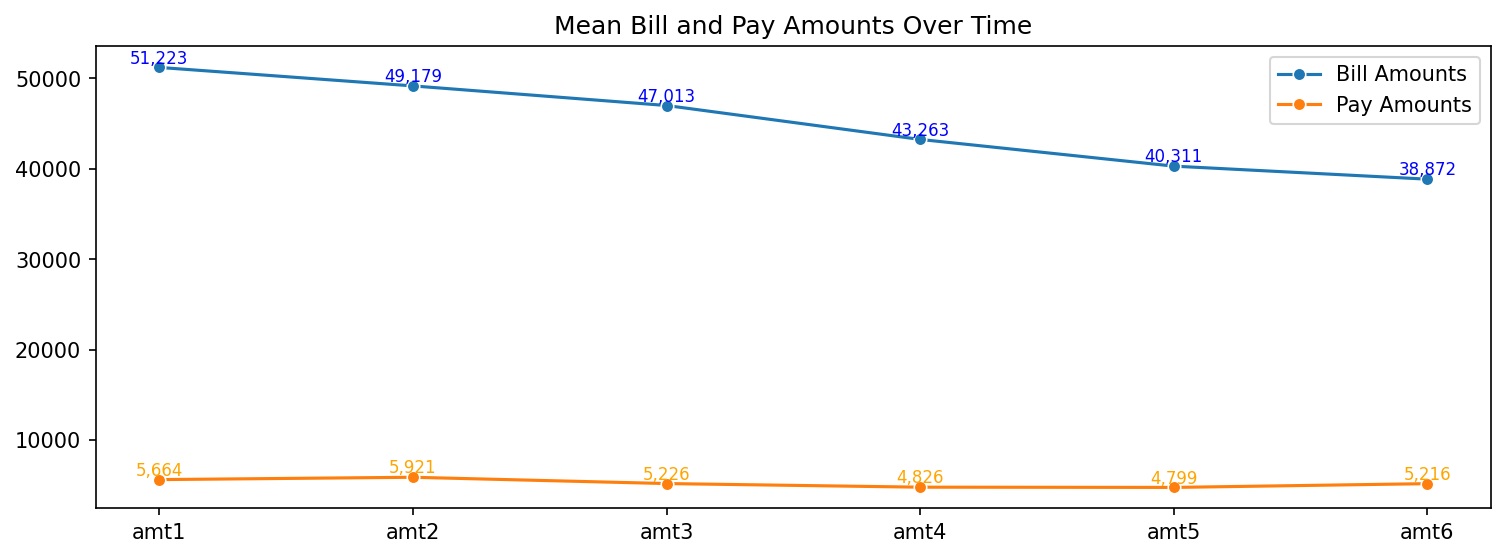

In [19]:
bill_cols = [
    "bill_amt1",
    "bill_amt2",
    "bill_amt3",
    "bill_amt4",
    "bill_amt5",
    "bill_amt6",
]
pay_cols = [
    "pay_amt1",
    "pay_amt2",
    "pay_amt3",
    "pay_amt4",
    "pay_amt5",
    "pay_amt6",
]
indexes = ["amt1", "amt2", "amt3", "amt4", "amt5", "amt6"]

bill_means = df_clean[bill_cols].mean()
pay_means = df_clean[pay_cols].mean()

bill_means.index = indexes
pay_means.index = indexes

fig = plt.figure(figsize=(12, 4), dpi=150)
ax = sns.lineplot(
    x=bill_means.index, y=bill_means.values, label="Bill Amounts", marker="o"
)
ax = sns.lineplot(
    x=pay_means.index, y=pay_means.values, label="Pay Amounts", marker="o"
)

# Annotate bill means
for i, (x, y) in enumerate(zip(bill_means.index, bill_means.values)):
    ax.text(x, y, f"{y:,.0f}", ha="center", va="bottom", fontsize=8, color="blue")

# Annotate pay means
for i, (x, y) in enumerate(zip(pay_means.index, pay_means.values)):
    ax.text(x, y, f"{y:,.0f}", ha="center", va="bottom", fontsize=8, color="orange")

plt.title("Mean Bill and Pay Amounts Over Time")
plt.xlabel("")
plt.show()

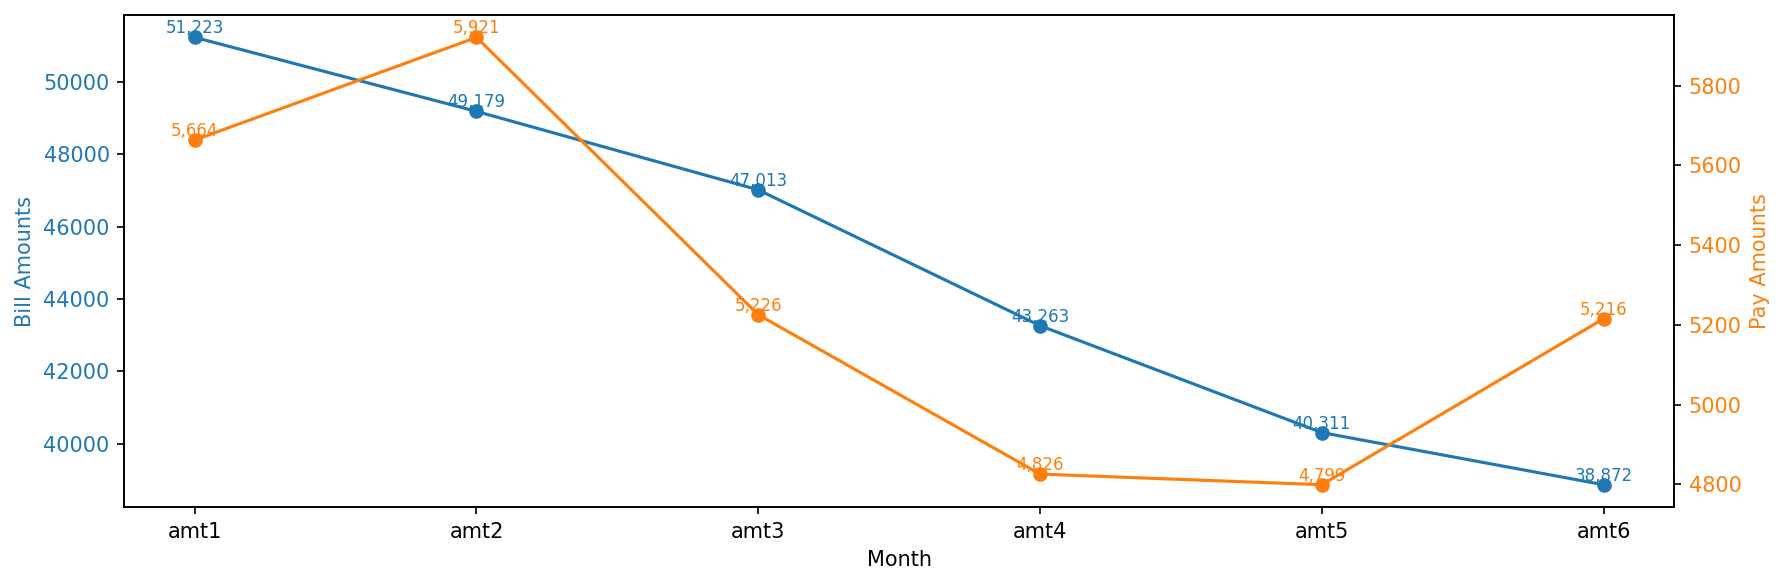

In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 4), dpi=150)

color1 = "tab:blue"
color2 = "tab:orange"

# Plot bill_means on primary y-axis
ax1.set_xlabel("Month")
ax1.set_ylabel("Bill Amounts", color=color1)
ax1.plot(
    bill_means.index, bill_means.values, label="Bill Amounts", marker="o", color=color1
)
for x, y in zip(bill_means.index, bill_means.values):
    ax1.text(x, y, f"{y:,.0f}", ha="center", va="bottom", fontsize=8, color=color1)
ax1.tick_params(axis="y", labelcolor=color1)

# Create secondary y-axis
ax2 = ax1.twinx()
ax2.set_ylabel("Pay Amounts", color=color2)
ax2.plot(
    pay_means.index, pay_means.values, label="Pay Amounts", marker="o", color=color2
)
for x, y in zip(pay_means.index, pay_means.values):
    ax2.text(x, y, f"{y:,.0f}", ha="center", va="bottom", fontsize=8, color=color2)
ax2.tick_params(axis="y", labelcolor=color2)

plt.title("Mean Bill and Pay Amounts Over Time")
plt.xlabel("")
plt.show()

## Correlation and Relationships

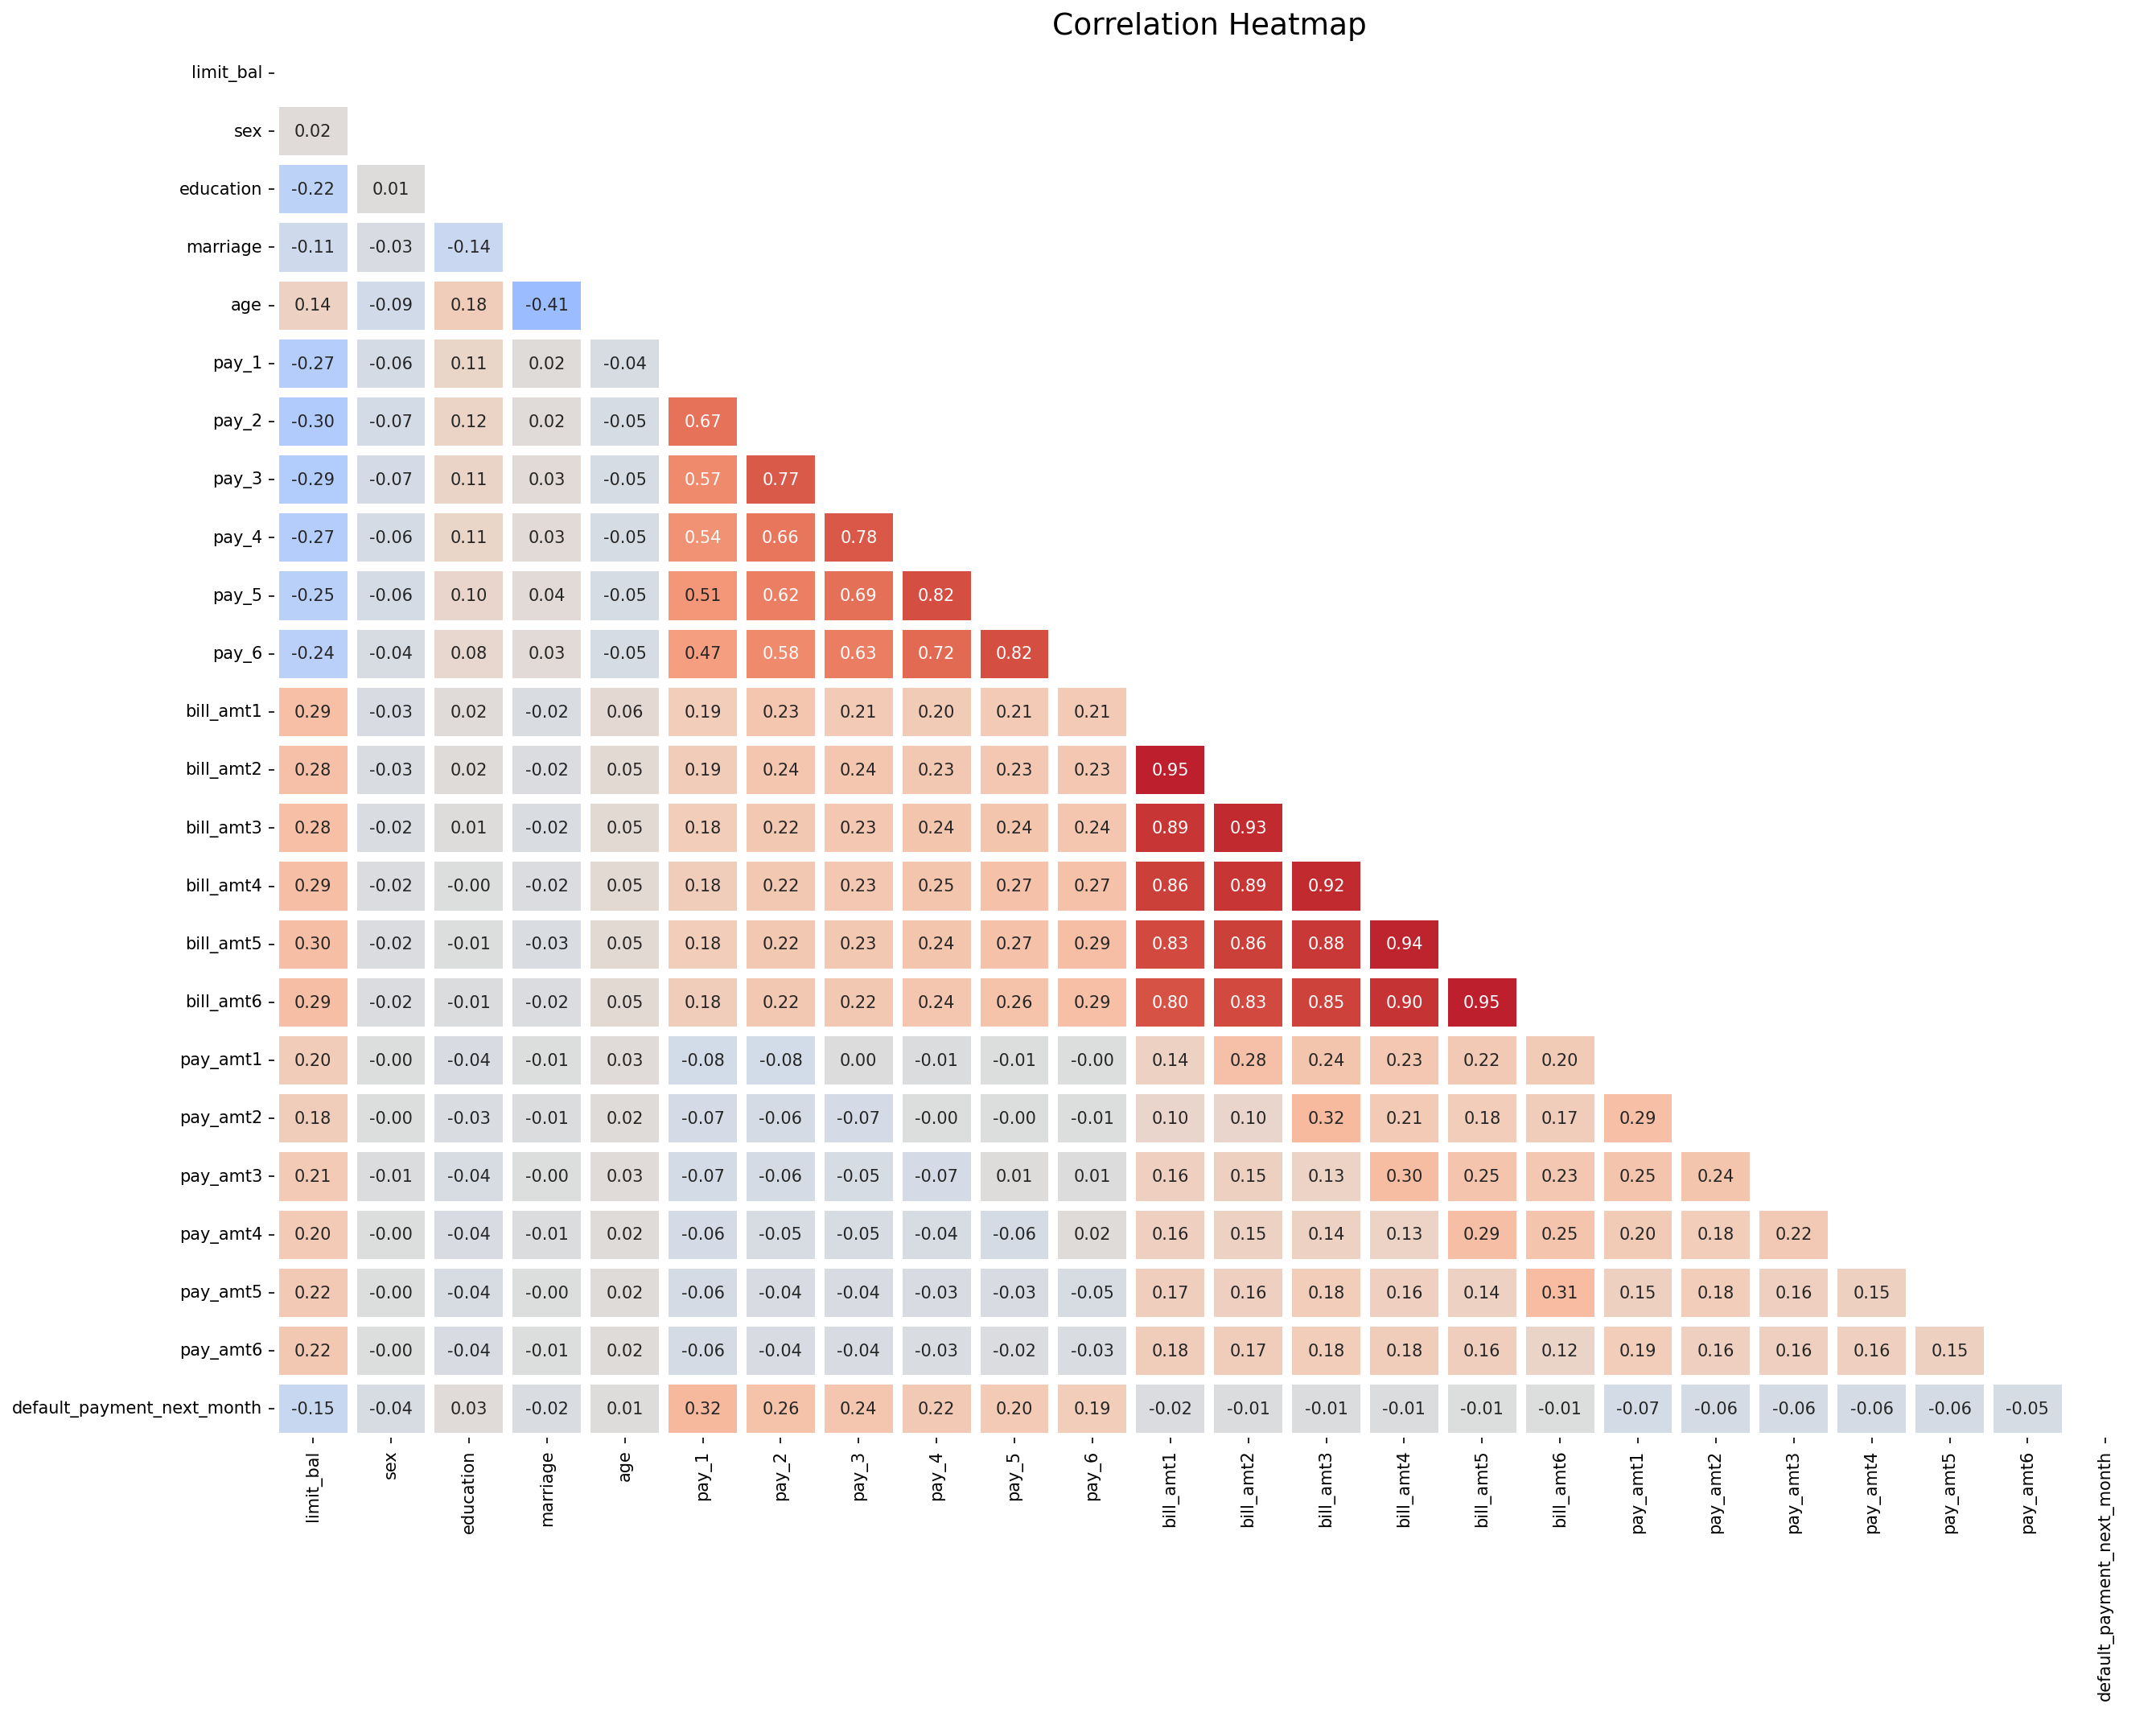

In [20]:
corrs = df_clean.drop(columns=["id"]).corr()

fig, ax = plt.subplots(figsize=(20, 15), dpi=150)

mask = np.triu(np.ones_like(corrs, dtype=bool))
cmap = sns.color_palette("coolwarm", as_cmap=True)

sns.heatmap(
    data=corrs,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap=cmap,
    linewidths=5,
    vmin=-1,
    vmax=1,
    cbar=False,
)

yticks = [i for i in corrs.index]
xticks = [i for i in corrs.columns]
plt.yticks(plt.yticks()[0], labels=yticks, rotation=0)
plt.xticks(plt.xticks()[0], labels=xticks)
plt.title("Correlation Heatmap", fontsize=18)
plt.show()

# Feature Engineering

In [21]:
df_engineered = df_clean.copy()

## Create New Features

### Pay Date

- `-1` = paid early  
- `0` = paid in full  
- `1~9` = months delayed

In [22]:
mask = df_engineered.columns[df_engineered.columns.str.contains("pay_")]
mask = mask[~mask.str.contains("amt")]

num_pay_early = (df_engineered[mask] < 0).sum(axis=1)
num_pay_on_time = (df_engineered[mask] == 0).sum(axis=1)
num_pay_delayed = (df_engineered[mask] > 0).sum(axis=1)
avg_pay_delay = (df_engineered[mask]).mean(axis=1)
max_pay_delay = (df_engineered[mask]).max(axis=1)

df_engineered = df_engineered.assign(
    num_pay_early=num_pay_early,
    num_pay_on_time=num_pay_on_time,
    num_pay_delayed=num_pay_delayed,
    avg_pay_delay=avg_pay_delay,
    max_pay_delay=max_pay_delay,
)

### Bill Amount

In [23]:
mask = df_engineered.columns[df_engineered.columns.str.contains("bill_amt")]

total_bill_amt = df_engineered[mask].sum(axis=1)
avg_bill_amt = df_engineered[mask].mean(axis=1)
max_bill_amt = df_engineered[mask].max(axis=1)
bill_trend = df_engineered[mask].iloc[:, -1] - df_engineered[mask].iloc[:, 0]
bill_std = df_engineered[mask].std(axis=1)

df_engineered = df_engineered.assign(
    total_bill_amt=total_bill_amt,
    avg_bill_amt=avg_bill_amt,
    max_bill_amt=max_bill_amt,
    bill_trend=bill_trend,
    bill_std=bill_std,
)

### Pay Amount

In [24]:
mask = df_engineered.columns[df_engineered.columns.str.contains("pay_amt")]

total_pay_amt = df_engineered[mask].sum(axis=1)
avg_pay_amt = df_engineered[mask].mean(axis=1)
max_pay_amt = df_engineered[mask].max(axis=1)
pay_trend = df_engineered[mask].iloc[:, -1] - df_engineered[mask].iloc[:, 0]
pay_std = df_engineered[mask].std(axis=1)

df_engineered = df_engineered.assign(
    total_pay_amt=total_pay_amt,
    avg_pay_amt=avg_pay_amt,
    max_pay_amt=max_pay_amt,
    pay_trend=pay_trend,
    pay_std=pay_std,
)

### Payment-to-Bill Ratios

In [25]:
mask_bill = [
    "bill_amt1",
    "bill_amt2",
    "bill_amt3",
    "bill_amt4",
    "bill_amt5",
    "bill_amt6",
]
pay_bill = [
    "pay_amt1",
    "pay_amt2",
    "pay_amt3",
    "pay_amt4",
    "pay_amt5",
    "pay_amt6",
]
epsilon = 1e-6

# - Monthly ratios: `PAY_AMTn` / `BILL_AMTn` for each month (handle division by zero)
pay_to_bill_ratios = df_engineered[pay_bill].values / (
    df_engineered[mask_bill].values + epsilon
)
for i in range(pay_to_bill_ratios.shape[1]):
    col_name = f"pay_to_bill_ratio_{i + 1}"
    df_engineered[col_name] = pay_to_bill_ratios[:, i]
    df_engineered[col_name] = df_engineered[col_name].fillna(0)


# - `avg_pay_to_bill_ratio` = Average ratio over 6 months
mask = [col for col in df_engineered.columns if col.startswith("pay_to_bill_ratio_")]
avg_pay_to_bill_ratio = df_engineered[mask].mean(axis=1)
df_engineered = df_engineered.assign(avg_pay_to_bill_ratio=avg_pay_to_bill_ratio)

# - `min_pay_to_bill_ratio` and `max_pay_to_bill_ratio`
min_pay_to_bill_ratio = df_engineered[mask].min(axis=1)
df_engineered = df_engineered.assign(min_pay_to_bill_ratio=min_pay_to_bill_ratio)

# - `max_pay_to_bill_ratio` and `max_pay_to_bill_ratio`
max_pay_to_bill_ratio = df_engineered[mask].max(axis=1)
df_engineered = df_engineered.assign(max_pay_to_bill_ratio=max_pay_to_bill_ratio)

## Encoding

In [26]:
# Sex

df_engineered = (df_engineered
    .assign(is_male=lambda df_: df_["sex"].map({1: 1, 2: 0}))
    .drop(columns=["sex"])
)

In [27]:
# Marriage

encoder = OneHotEncoder(sparse_output=False, drop="if_binary")

marriage_encoded = encoder.fit_transform(df_engineered[["marriage"]])
encoded_cols = encoder.get_feature_names_out(["marriage"])
marriage_encoded_df = pd.DataFrame(marriage_encoded, columns=encoded_cols, index=df_engineered.index)
df_engineered = pd.concat([df_engineered, marriage_encoded_df], axis=1)
df_engineered = df_engineered.drop(columns=["marriage"])

In [28]:
# Education

encoder = OneHotEncoder(sparse_output=False, drop="if_binary")

education_encoded = encoder.fit_transform(df_engineered[["education"]])
encoded_cols = encoder.get_feature_names_out(["education"])
education_encoded_df = pd.DataFrame(education_encoded, columns=encoded_cols, index=df_engineered.index)
df_engineered = pd.concat([df_engineered, education_encoded_df], axis=1)
df_engineered = df_engineered.drop(columns=["education"])

## Normalization

In [29]:
features = [col for col in df_engineered.columns if col not in ["id", "default_payment_next_month"]]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_engineered[features] = scaler.fit_transform(df_engineered[features])

## Eye Test

In [30]:
utils.print_df_in_chunks(df_engineered, n=10)

|    |   id |   limit_bal |       age |      pay_1 |    pay_2 |     pay_3 |     pay_4 |     pay_5 |     pay_6 |   bill_amt1 |
|----+------+-------------+-----------+------------+----------+-----------+-----------+-----------+-----------+-------------|
|  0 |    1 |   -1.13672  | -1.24602  |  1.79456   | 1.78235  | -0.696663 | -0.666599 | -1.53005  | -1.48604  |   -0.642501 |
|  1 |    2 |   -0.365981 | -1.02905  | -0.874991  | 1.78235  |  0.138865 |  0.188746 |  0.234917 |  1.99232  |   -0.659219 |
|  2 |    3 |   -0.597202 | -0.161156 |  0.0148605 | 0.111736 |  0.138865 |  0.188746 |  0.234917 |  0.253137 |   -0.29856  |
|  3 |    4 |   -0.905498 |  0.164303 |  0.0148605 | 0.111736 |  0.138865 |  0.188746 |  0.234917 |  0.253137 |   -0.057491 |
|  4 |    5 |   -0.905498 |  2.33403  | -0.874991  | 0.111736 | -0.696663 |  0.188746 |  0.234917 |  0.253137 |   -0.578618 |

|    |   bill_amt2 |   bill_amt3 |   bill_amt4 |   bill_amt5 |   bill_amt6 |   pay_amt1 |   pay_amt2 |   pay_amt3 |  

In [31]:
df_engineered.mean()[df_engineered.mean().abs() > epsilon]

id                           15,000.500
default_payment_next_month        0.221
dtype: float64

In [32]:
df_engineered.std()[(df_engineered.std() - 1) > 0.0001]

id   8,660.398
dtype: float64

# Train Val Test Splitting

In [48]:
ids = df_engineered["id"]
labels = df_engineered["default_payment_next_month"]
features = df_engineered.drop(columns=["id", "default_payment_next_month"])

x_train, x_val, x_test, y_train, y_val, y_test = utils.split_dataset(x=features, y=labels, test_size=0.2, val_size=0.1, random_state=None)

# Statistical Anomaly Detection

## z-score

In [85]:
# Calculate z-scores for each feature in the training set


def calculate_z_scores(xs):
    mean = xs.mean()
    std = xs.std()
    z_scores = (xs - mean) / std
    return z_scores


z_score_result = x_train.copy()

for col in x_train.columns:
    z_scores = calculate_z_scores(x_train[col])
    z_score_result[col] = z_scores

# If abs(z_score_result) > 3, then it is an outlier according to each feature
z_score_result = (z_score_result.abs() > 3).astype(int)

# Now display the accuracy per feature
z_score_accs = {}
for col in z_score_result.columns:
    score = utils.return_clf_score(y_train.values, z_score_result[col].values)
    z_score_accs[col] = score.acc


z_score_accs_sorted = dict(
    sorted(z_score_accs.items(), key=lambda item: item[1], reverse=True)
)

print("Top 5 features:")
for col, acc in islice(z_score_accs_sorted.items(), 5):
    print(f"    {col}: {acc:.3f}")

print("Bottom 5 features:")
for col, acc in list(z_score_accs_sorted.items())[-5:]:
    print(f"    {col}: {acc:.3f}")

Top 5 features:
    num_pay_delayed: 0.794
    avg_pay_delay: 0.779
    pay_5: 0.779
    pay_4: 0.779
    pay_6: 0.779
Bottom 5 features:
    max_pay_amt: 0.762
    pay_trend: 0.762
    pay_std: 0.762
    bill_std: 0.761
    bill_trend: 0.760


In [104]:
feature = x_val["num_pay_delayed"].values
y_val_preds = (calculate_z_scores(feature) > 3) * 1

scores = utils.return_clf_score(y_val.values, y_val_preds)
utils.print_clf_score(scores, title="Z-Score Classification Report on Validation Set")


=== Z-Score Classification Report on Validation Set ===
Accuracy : 0.8027
F1 Score : 0.7460
Precision: 0.7940
Recall   : 0.8027
Confusion Matrix (normalized):
[[0.9867691  0.0132309 ]
 [0.85388128 0.14611872]]


## IQR

## Mahalanobis

## PCA